<a href="https://colab.research.google.com/github/savpatpanda/protein/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/savpatpanda/protein.git
%cd protein
!ls 
!pip3 install -r requirements.txt
# to push to GitHub, File > Save a copy in GitHub

Cloning into 'protein'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 86 (delta 40), reused 43 (delta 14), pack-reused 0
Unpacking objects: 100% (86/86), done.
/content/protein
data  notebook.ipynb  plotting.py  proteinModel.py  requirements.txt
     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 296kB 21.6MB/s 


In [ ]:
import numpy as np
from plotting import plotSpheres
def getFractionalToCartesianRotationMatrix(a, b, c, alpha, beta, gamma):
  alpha = alpha*np.pi/180
  beta  = beta*np.pi/180
  gamma  = gamma*np.pi/180

  n2 = (np.cos(alpha) - np.cos(gamma) * np.cos(beta)) / np.sin(gamma)
  M  = np.array([ [a,0,0],
                  [b*np.cos(gamma),b*np.sin(gamma),0], 
                  [c*np.cos(beta), c*n2, c*np.sqrt(np.sin(beta)**2-n2**2)]
                 ])
  return M


[[ 1.64328909  3.66464     0.73738568]
 [ 2.7647311   3.160752    0.08938008]
 [ 3.31124065  1.943568    0.45807292]
 [ 2.7665936   1.223728    1.5082889 ]
 [ 1.66647673  1.714528    2.16746701]
 [ 1.10873718  2.918624    1.79877417]
 [ 0.9687101   4.947264    0.41338288]
 [ 4.19177146  4.822928   -0.69269564]
 [ 4.67823603  5.490416   -1.9440168 ]
 [ 1.44030284  5.621296   -0.58097054]
 [-0.00787677  5.320272    1.07256099]
 [ 3.33524274  3.808608   -0.99435342]
 [ 4.47360496  5.114136    0.40221037]
 [ 4.16363519  1.5555088  -0.10613885]
 [ 3.20618445  0.2591424   1.7797809 ]
 [ 1.27388704  1.11248     3.00317078]
 [ 0.2498672   3.272       2.32723391]
 [ 5.34489471  6.28224    -1.56415145]
 [ 3.84326969  5.82416    -2.45795228]
 [ 5.10126693  4.77712    -2.68140249]
 [ 0.87355715  6.449112   -0.71727517]]


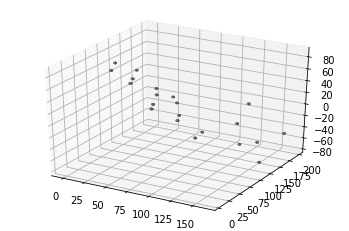

In [ ]:
from gemmi import cif 
%matplotlib inline
import matplotlib.pyplot as plt

parseCIFNum = lambda num: float(num[:-4] if num[-1] == ')' else num)

def parseCIFFile(cifFileName):
  doc = cif.read_file("./data/185472.cif")
  block = doc.sole_block()    
  fractionalSpace = [ block.find_pair("_cell_length_a"),
                      block.find_pair("_cell_length_b"),
                      block.find_pair("_cell_length_c"),
                      block.find_pair("_cell_angle_alpha"),
                      block.find_pair("_cell_angle_beta"),
                      block.find_pair("_cell_angle_gamma") ]

  fractionalSpace = map(lambda x: parseCIFNum(x[1]), fractionalSpace)
  rotationMatrix = getFractionalToCartesianRotationMatrix(*fractionalSpace)
  
  x = [parseCIFNum(x) for x in list(block.find_loop("_atom_site_fract_x"))]
  y = [parseCIFNum(x) for x in list(block.find_loop("_atom_site_fract_y"))]
  z = [parseCIFNum(x) for x in list(block.find_loop("_atom_site_fract_z"))]
  coords = np.array(list(zip(x,y,z)))

  return coords, rotationMatrix
  
try:
  coords, rotationMatrix = parseCIFFile("./data/185472.cif")
  cartesian = np.matmul(coords, rotationMatrix)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  print(cartesian)
  plotSpheres(cartesian*30, ax)
  plt.show()
  
except Exception as e:
  print(e)

In [ ]:
class Residue():
  def __init__ (self, atoms, meanX, meanY, meanZ):
    self.atoms = atoms
    self.position = (meanX, meanY, meanZ)


class Atom():
  def __init__(self, x, y, z, atomType, residueComponents, charge):
    self.position = (x,y,z)
    self.atomType = atomType
    self.residueComponents = residueComponents
    self.charge = charge
  def __repr__(self):
    return f"{self.atomType} at {self.position}"

def plotAtoms(ax, atoms: list, color: str, radius: float):
  plotSpheres(atoms, ax, radius = radius, color = color)

In [ ]:
import pandas as pd

def getResidues(pdbFile:str):
  pdb = open(pdbFile)
  data = [] ##residueCode, residueNumber, x, y, z, atomType - 2,5,6,7,8, 11
  positions = [2,5,6,7,8]

  for line in pdb:
      maxSubLength = len("ATOM    179  O   LYS A  22       7.513 -14.365  20.571")
      elements = line[:maxSubLength].split()
      if elements[0] == "ATOM" or "HETATM" and elements[2] not in ["CA", "N", "O", "C"]:
          if len(elements) < 9:
            left = elements[2][:3]
            right = elements[2][3:]
            elements[2] = left
            elements.insert(3,right)

          item = []
          for i in positions:
            if i == 5:
              item.append(int(elements[i]))
            elif i in [6,7,8]:
              item.append(float(elements[i]))
            else:
              item.append(elements[i])
          item.append(line[-4])
            
          data.append(item)

  df = pd.DataFrame(data = data, columns = ["residueCode", "residueNumber", "x", "y", "z", "atomType"])
  df = df.groupby(by = ['residueNumber'])

  residues = []
  allProteinAtoms = []
  for key, item in df:
      atoms = []
      atomDf = df.get_group(key)
      for index, row in atomDf.iterrows():
        atoms.append(Atom(row["x"], row["y"], row["z"], row["atomType"], row["residueCode"]))
      residues.append(Residue(atoms, atomDf["x"].mean(), atomDf["y"].mean(), atomDf["z"].mean()))
      allProteinAtoms.extend(atoms)
  return allProteinAtoms, residues

[[ 1.64328909  3.66464     0.73738568]
 [ 2.7647311   3.160752    0.08938008]
 [ 3.31124065  1.943568    0.45807292]
 [ 2.7665936   1.223728    1.5082889 ]
 [ 1.66647673  1.714528    2.16746701]
 [ 1.10873718  2.918624    1.79877417]
 [ 0.9687101   4.947264    0.41338288]
 [ 4.19177146  4.822928   -0.69269564]
 [ 4.67823603  5.490416   -1.9440168 ]
 [ 1.44030284  5.621296   -0.58097054]
 [-0.00787677  5.320272    1.07256099]
 [ 3.33524274  3.808608   -0.99435342]
 [ 4.47360496  5.114136    0.40221037]
 [ 4.16363519  1.5555088  -0.10613885]
 [ 3.20618445  0.2591424   1.7797809 ]
 [ 1.27388704  1.11248     3.00317078]
 [ 0.2498672   3.272       2.32723391]
 [ 5.34489471  6.28224    -1.56415145]
 [ 3.84326969  5.82416    -2.45795228]
 [ 5.10126693  4.77712    -2.68140249]
 [ 0.87355715  6.449112   -0.71727517]]
[C at (-23.256, 45.264, 65.451), C at (-19.915, 44.52, 67.362), C at (-18.211, 44.449, 64.689), C at (-17.572, 44.171, 63.305), C at (-18.641, 43.89, 62.257), C at (-16.819, 45.393

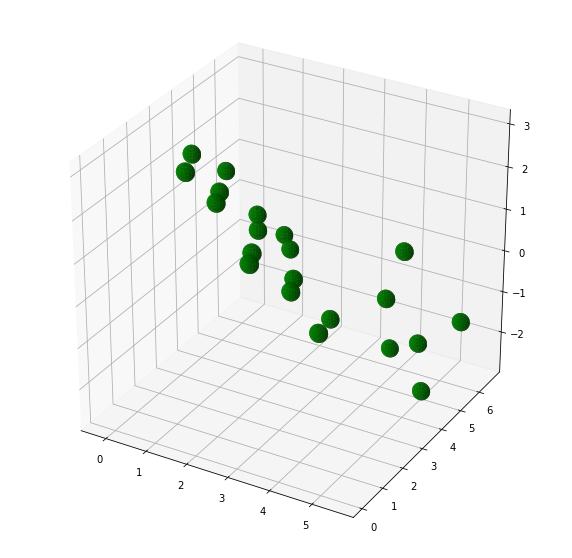

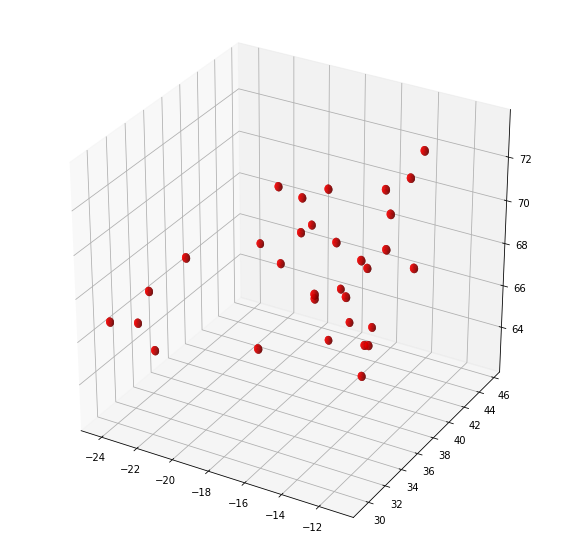

In [ ]:
coords, rotationMatrix = parseCIFFile("./data/185472.cif")
atoms, residues = getResidues('data/1ikf.pdb')
cartesian = np.matmul(coords, rotationMatrix)
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
print(cartesian)
print(atoms)
plotAtoms(ax, cartesian, color = "green", radius = 0.2)
plt.show()
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
plotAtoms(ax, [atom.position for atom in atoms], color = "red", radius = 0.2)


In [ ]:
wellCoeff = {
    "C" : 0.15, 
    "N" : 0.16,
    "O" : 0.2,
    "S" : 0.2,
    "H" : 0.02,
    "P" : 0.36758504
} #kcal / mol

atomicRadii = {
    "C" : 70, 
    "N" : 65,
    "O" : 60,
    "S" : 100,
    "H" : 25,
    "P" : 98
} #picometers

def LJ(type1, type2, distance):
  rij_min = (atomicRadii[type1] + atomicRadii[type2])/2
  ljEnergy = math.sqrt(wellCoeff[type1]*wellCoeff[type2]) * ((rij_min/distance)**12 - 2*(rij_min/distance)**6)
  return ljEnergy

def electro(atom1, atom2, distance):
  cutoffCharge = 1 
  dielectric = 80.1 #H20: https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Book%3A_Physical_Methods_in_Chemistry_and_Nano_Science_(Barron)/02%3A_Physical_and_Thermal_Analysis/2.09%3A_Electrical_Permittivity_Characterization_of_Aqueous_Solutions
  if atom1.charge < cutoffCharge or atom2.charge < cutoffCharge:
    return 0
  else:
    electroEnergy = (atom1.charge) * (atom2.charge) / (dielectric * distance)
    return electroEnergy

def potentialEnergy(proteinSet, compoundSet):
  totalEnergy = 0
  cutOffDistance = 1e9
  for i in proteinSet:
    for j in compoundSet:
      distance = math.sqrt( (i.position[0] - j.position[0])**2 + (i.position[1] - j.position[1])**2 + (i.position[2] - j.position[2])**2)
      if distance > cutOffDistance: #optional cutoff for particles too far away
        continue
      totalEnergy += (LJ(i.atomType, j.atomType, distance) + electro(i.atomType, j.atomType, distance)
  return totalEnergy

{'CC': 0.15, 'CN': 0.155, 'CO': 0.173, 'CS': 0.173, 'CH': 0.055, 'NN': 0.16, 'NO': 0.179, 'NS': 0.179, 'HN': 0.057, 'OO': 0.2, 'OS': 0.2, 'HO': 0.063, 'SS': 0.2, 'HS': 0.063, 'HH': 0.02}


# New Section